In [6]:
#Dependencies
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from datetime import date
import math
from pandas.api.types import CategoricalDtype
import holidays
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

#Drive Mount
drive.mount('/content/drive')
directory = '/content/drive/MyDrive/Data Projects/Parking Citations/Files'

#Dataframe Settings
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.mode.chained_assignment = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Import Daily Revenue From Exploratory Analysis
Daily_Revenue = pd.read_csv(f'{directory}/Daily_Revenue.csv')
Daily_Revenue['Date'] = pd.to_datetime(Daily_Revenue.Date) 

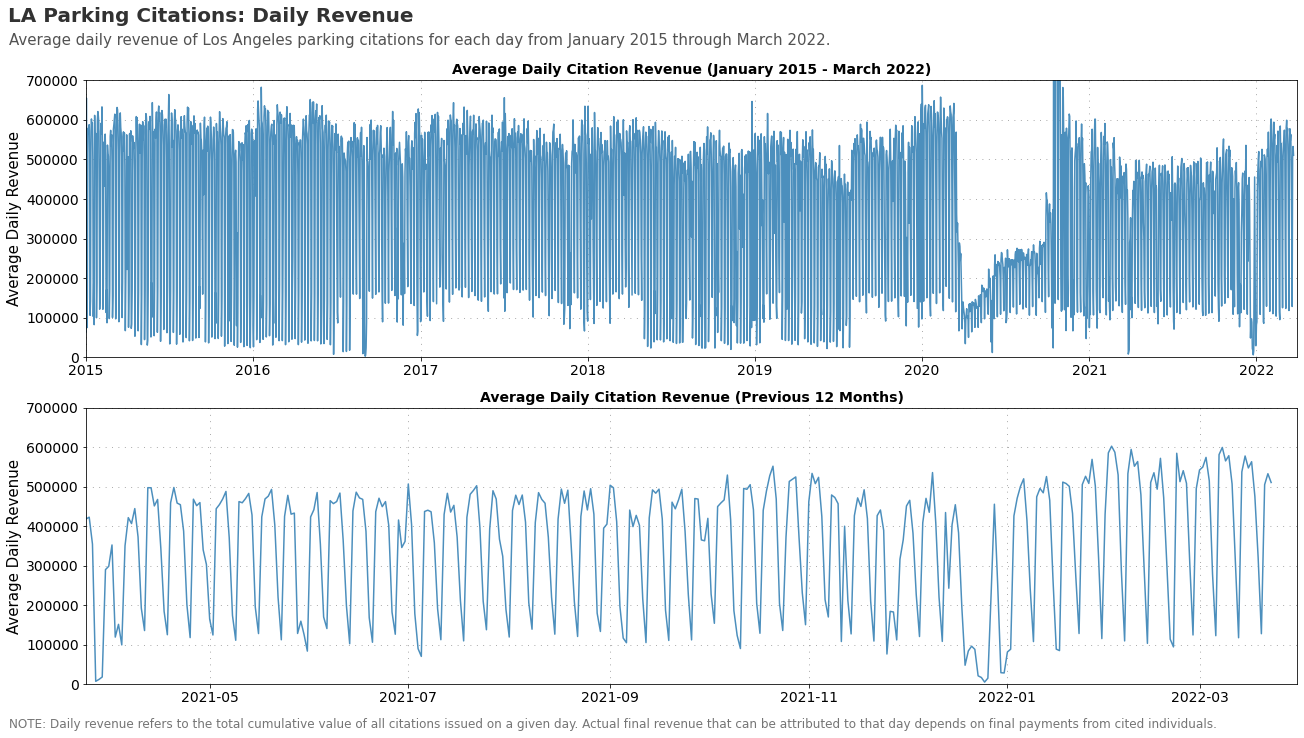

In [5]:
#Plotting Daily Revenue
ax = plt.figure(figsize = (18, 9), constrained_layout=True)
gs = ax.add_gridspec(2, 1)

#Figure annotations
plt.figtext(0.003, 1.059,'LA Parking Citations: Daily Revenue', fontfamily='sans-serif', fontsize=20, fontweight='bold', color='#323232')
plt.figtext(0.004, 1.024, "Average daily revenue of Los Angeles parking citations for each day from January 2015 through March 2022.", fontfamily='sans-serif',fontsize=15,fontweight='regular',color='#525252')
plt.figtext(0.004, -0.03, 'NOTE: Daily revenue refers to the total cumulative value of all citations issued on a given day. Actual final revenue that can be attributed to that day depends on final payments from cited individuals.', fontsize = 12, color = '#757575')

#Plot 1 Specifications
ax1 = ax.add_subplot(gs[0,0])
plt.title('Average Daily Citation Revenue (January 2015 - March 2022)', fontweight='bold', fontsize=14, fontfamily='sans-serif')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 1, zorder = 0,  dashes = (1,7))
plt.grid(color = 'gray', linestyle = ':', axis = 'y', alpha = 1, zorder = 0,  dashes = (1,7))
sns.lineplot(data=Daily_Revenue, x='Date', y='Daily_Revenue', ax=ax1, color ='#4c8fbd') 
plt.xlabel('', fontsize = 15, fontfamily='sans-serif')
plt.ylabel('Average Daily Revenue', fontsize = 15, fontfamily='sans-serif')
plt.xticks(fontsize=14, fontfamily='sans-serif');
plt.yticks(fontsize=14, fontfamily='sans-serif');
plt.ylim(0,700000);
ax1.set_xlim([date(2015, 1, 1), date(2022, 3, 31)])

#Plot 2 Specifications
ax2 = ax.add_subplot(gs[1,0])
plt.title('Average Daily Citation Revenue (Previous 12 Months)', fontweight='bold', fontsize=14, fontfamily='sans-serif')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 1, zorder = 0,  dashes = (1,7))
plt.grid(color = 'gray', linestyle = ':', axis = 'y', alpha = 1, zorder = 0,  dashes = (1,7))
sns.lineplot(data=Daily_Revenue, x='Date', y='Daily_Revenue', ax=ax2, color ='#4c8fbd') 
plt.xlabel('', fontsize = 15, fontfamily='sans-serif')
plt.ylabel('Average Daily Revenue', fontsize = 15, fontfamily='sans-serif')
plt.xticks(fontsize=14, fontfamily='sans-serif');
plt.yticks(fontsize=14, fontfamily='sans-serif');
plt.ylim(0,700000);
ax2.set_xlim([date(2021, 3, 24), date(2022, 3, 31)])

ax.patch.set_facecolor('white')

# Model 

In [8]:
#Split Data to predict Q1 2022 (January 1 - March 31)
split_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
df_train = Daily_Revenue.loc[Daily_Revenue['Date'] <= split_date].copy()
df_test = Daily_Revenue.loc[Daily_Revenue['Date'] > split_date].copy()

In [9]:
#Function to seperate out feature from date
def create_features(df):
  df['dayofweek'] = df['Date'].dt.dayofweek
  df['month'] = df['Date'].dt.month
  df['year'] = df['Date'].dt.year
  df['dayofyear'] = df['Date'].dt.dayofyear
  df['dayofmonth'] = df['Date'].dt.day
  df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)
  us_holidays = holidays.US()
  def get_holiday(x):
      return x in us_holidays
  df['Holiday'] = df['Date'].apply(get_holiday)
  df['Holiday'] = df['Holiday'].replace(False, 0)
  df['Holiday'] = df['Holiday'].replace(True, 1)
  df.set_index('Date',inplace=True)

#Getting Date Features for Train and Test
create_features(df_train)
create_features(df_test)

#Splitting to X and Y
x_train = df_train[['dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Holiday']]
y_train = df_train[['Daily_Revenue']]
x_test = df_test[['dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Holiday']]
y_test = df_test[['Daily_Revenue']]

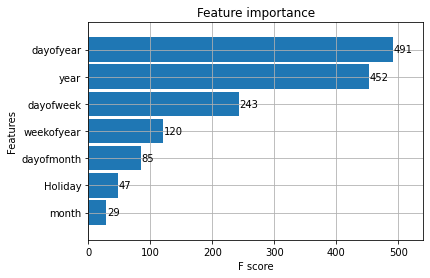

In [10]:
#Fitting Model
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=50, verbose=False)

#Plot Feature Importance
_ = plot_importance(reg, height=0.9)

#Save Predicted Values
predicted = y_test.copy()
predicted['predicted'] = reg.predict(x_test)

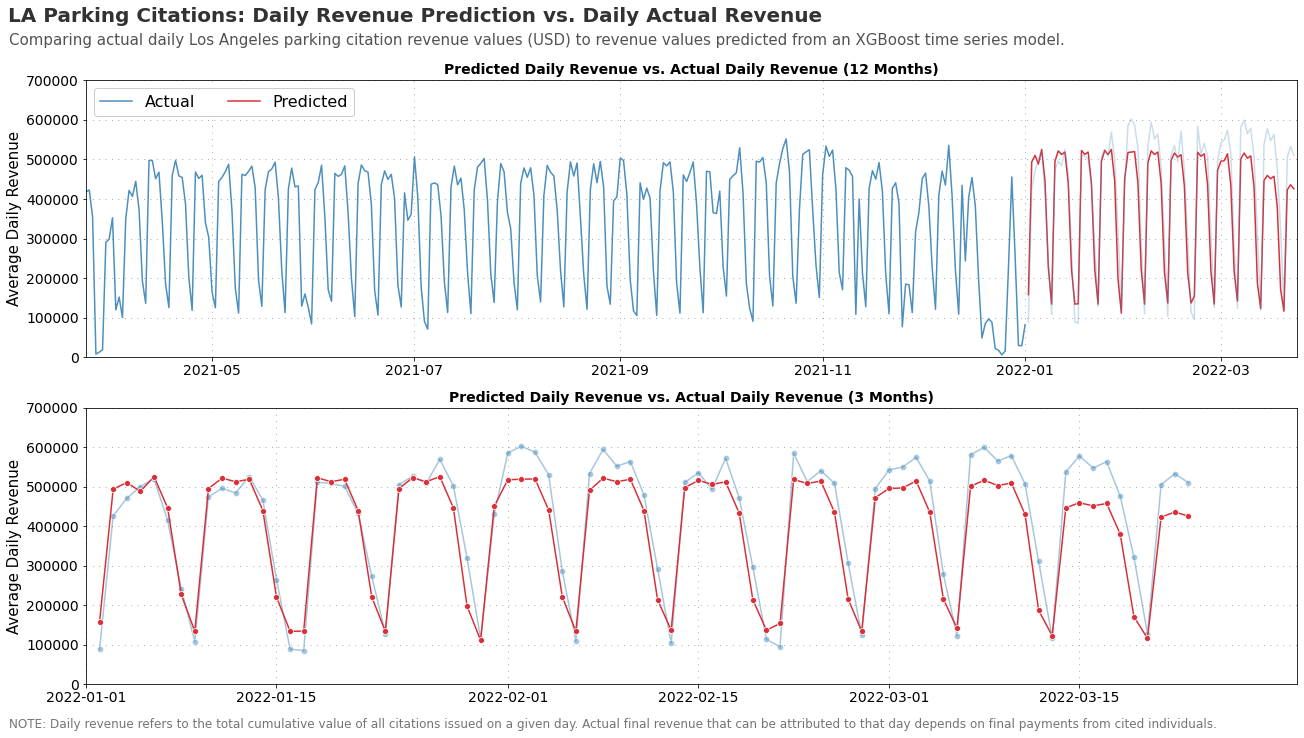

In [13]:
#Plotting Predicted Values
ax = plt.figure(figsize = (18, 9), constrained_layout=True)
gs = ax.add_gridspec(2, 1)

#Figure annotations
plt.figtext(0.003, 1.059,'LA Parking Citations: Daily Revenue Prediction vs. Daily Actual Revenue', fontfamily='sans-serif', fontsize=20, fontweight='bold', color='#323232')
plt.figtext(0.004, 1.024, "Comparing actual daily Los Angeles parking citation revenue values (USD) to revenue values predicted from an XGBoost time series model.", fontfamily='sans-serif',fontsize=15,fontweight='regular',color='#525252')
plt.figtext(0.004, -0.03, 'NOTE: Daily revenue refers to the total cumulative value of all citations issued on a given day. Actual final revenue that can be attributed to that day depends on final payments from cited individuals.', fontsize = 12, color = '#757575')

#Plot 1 Specifications
ax1 = ax.add_subplot(gs[0,0])
plt.title('Predicted Daily Revenue vs. Actual Daily Revenue (12 Months)', fontweight='bold', fontsize=14, fontfamily='sans-serif')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 1, zorder = 0,  dashes = (1,7))
plt.grid(color = 'gray', linestyle = ':', axis = 'y', alpha = 1, zorder = 0,  dashes = (1,7))
sns.lineplot(data=df_train, x='Date', y='Daily_Revenue', ax=ax1, color ='#4c8fbd')  
sns.lineplot(data=predicted, x='Date', y='predicted', ax=ax1, color ='#d93038') 
sns.lineplot(data=df_test, x='Date', y='Daily_Revenue', ax=ax1, color ='#4c8fbd', alpha=0.3)
plt.xlabel('', fontsize = 15, fontfamily='sans-serif')
plt.ylabel('Average Daily Revenue', fontsize = 15, fontfamily='sans-serif')
plt.xticks(fontsize=14, fontfamily='sans-serif');
plt.yticks(fontsize=14, fontfamily='sans-serif');
plt.ylim(0,700000);
ax1.set_xlim([date(2021, 3, 24), date(2022, 3, 24)])
plt.legend(['Actual', 'Predicted'], loc="upper left", ncol = 2, frameon = True, fontsize = 16, framealpha=1)

#Plot 2 Specifications
ax2 = ax.add_subplot(gs[1,0])
plt.title('Predicted Daily Revenue vs. Actual Daily Revenue (3 Months)', fontweight='bold', fontsize=14, fontfamily='sans-serif')
plt.grid(color = 'gray', linestyle = ':', axis = 'x', alpha = 1, zorder = 0,  dashes = (1,7))
plt.grid(color = 'gray', linestyle = ':', axis = 'y', alpha = 1, zorder = 0,  dashes = (1,7))
sns.lineplot(data=df_test, x='Date', y='Daily_Revenue', ax=ax2, color ='#4c8fbd', alpha=0.5,marker='o') 
sns.lineplot(data=predicted, x='Date', y='predicted', ax=ax2, color ='#d93038',marker='o') 
plt.xlabel('', fontsize = 15, fontfamily='sans-serif')
plt.ylabel('Average Daily Revenue', fontsize = 15, fontfamily='sans-serif')
plt.xticks(fontsize=14, fontfamily='sans-serif');
plt.yticks(fontsize=14, fontfamily='sans-serif');
plt.ylim(0,700000);
ax2.set_xlim([date(2022, 1, 1), date(2022, 3, 31)])

ax.patch.set_facecolor('white')
ax.savefig(f'{directory}/Daily Revenue Prediction Comparison.png' , bbox_inches="tight", dpi=300)

##Model Evaluation

In [12]:
RMSE = round(sqrt(mean_squared_error(y_true=predicted['Daily_Revenue'], y_pred=predicted['predicted'])),2)
MAE = round(mean_absolute_error(y_true=predicted['Daily_Revenue'], y_pred=predicted['predicted']),2)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

MAPE = round(mean_absolute_percentage_error(predicted['Daily_Revenue'], predicted['predicted']),2)
print(f'RMSE: {RMSE}')
print(f'MAE: {MAE}')
print(f'MAPE: {MAPE}%')

RMSE: 59844.11
MAE: 49077.78
MAPE: 14.75%
